In [1]:
from immuno_ms2rescore_tools.file_utilities import PrositLib
import pandas as pd
import numpy as np
import xgboost as xgb
from math import sqrt
from math import acos
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import acos
import pickle

In [2]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

In [3]:
with open("data/training_data/training_upeps.pkl", "rb") as f:
    train_ovp = pickle.load(f)
train_ovp = list(train_ovp.astype(str))

# MS²PIP corr

In [4]:
def load_data(vector_filename, ion_type):
    # Read file
    if vector_filename.split(".")[-1] == "pkl":
        vectors = pd.read_pickle(vector_filename)
    elif vector_filename.split(".")[-1] == "h5":
        # vectors = pd.read_hdf(vector_filename, key='table', stop=1000)
        vectors = pd.read_hdf(vector_filename, key="table")
    else:
        print("Unsuported feature vector format")
        exit(1)

    # Extract targets for given ion type
    target_names = list(vectors.columns[vectors.columns.str.contains("targets")])
    if not "targets_{}".format(ion_type) in target_names:
        print("Targets for {} could not be found in vector file.".format(ion_type))
        print("Vector file only contains these targets: {}".format(target_names))
        exit(1)

    targets = vectors.pop("targets_{}".format(ion_type))
    target_names.remove("targets_{}".format(ion_type))
    for n in target_names:
        vectors.pop(n)

    # Get psmids
    psmids = vectors.pop("psmid")

    return (vectors, targets, psmids)

In [5]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)

In [6]:
def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    true = np.array(true)
    pred = np.array(pred)
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

In [7]:
proteomics_vectorsY, proteomics_targetsY, proteomics_psmidsY = load_data("data/evaluation_data/PXD008034/tryptic_test_vector.pkl", "Y")
immunopeptide_vectorsY, immunopeptide_targetsY, immunopeptide_psmidsY = load_data("data/evaluation_data/PXD005231/HLAI_test.pkl", "Y")
hlaII_vectorsY, hlaII_targetsY, hlaII_psmidsY = load_data("data/evaluation_data/PXD020011/HLAII_test.pkl", "Y")
chymotrypsin_vectorsY, chymotrypsin_targetsY, chymotrypsin_psmidsY = load_data("data/evaluation_data/PXD010154/chymotrypsin_test.pkl", "Y")

In [8]:
proteomics_testY = xgb.DMatrix(proteomics_vectorsY, label=proteomics_targetsY)
immunopeptide_testY = xgb.DMatrix(immunopeptide_vectorsY, label=immunopeptide_targetsY)
hlaII_testY = xgb.DMatrix(hlaII_vectorsY, label=hlaII_targetsY)
chymotrypsin_testY = xgb.DMatrix(chymotrypsin_vectorsY, label=chymotrypsin_targetsY)

In [9]:
proteomics_vectorsB, proteomics_targetsB, proteomics_psmidsB = load_data("data/evaluation_data/PXD008034/tryptic_test_vector.pkl", "B")
immunopeptide_vectorsB, immunopeptide_targetsB, immunopeptide_psmidsB = load_data("data/evaluation_data/PXD005231/HLAI_test.pkl", "B")
hlaII_vectorsB, hlaII_targetsB, hlaII_psmidsB = load_data("data/evaluation_data/PXD020011/HLAII_test.pkl", "B")
chymotrypsin_vectorsB, chymotrypsin_targetsB, chymotrypsin_psmidsB = load_data("data/evaluation_data/PXD010154/chymotrypsin_test.pkl", "B")


In [10]:
proteomics_testB = xgb.DMatrix(proteomics_vectorsB, label=proteomics_targetsB)
immunopeptide_testB = xgb.DMatrix(immunopeptide_vectorsB, label=immunopeptide_targetsB)
hlaII_testB = xgb.DMatrix(hlaII_vectorsB, label=hlaII_targetsB)
chymotrypsin_testB = xgb.DMatrix(chymotrypsin_vectorsB, label=chymotrypsin_targetsB)

In [11]:
Y_models = {}
B_models = {}

In [12]:
joint_Y = xgb.Booster({'nthread': 8})  
joint_Y.load_model("data/ms2pip_models/Hyperopt_joint_HCDy.xgboost")
Y_models["Immunopeptide model"] = joint_Y

joint_B = xgb.Booster({'nthread': 8})  
joint_B.load_model("data/ms2pip_models/Hyperopt_joint_HCDb.xgboost")
B_models["Immunopeptide model"] = joint_B

Immunopeptide_chymotrypsin_Y = xgb.Booster({'nthread': 8})  
Immunopeptide_chymotrypsin_Y.load_model("data/ms2pip_models/Immunopeptide_chymotrypsin_HCDy.xgboost")
Y_models["Immuno-chymotrypsin model"] = Immunopeptide_chymotrypsin_Y

Immunopeptide_chymotrypsin_B = xgb.Booster({'nthread': 8})  
Immunopeptide_chymotrypsin_B.load_model("data/ms2pip_models/Immunopeptide_chymotrypsin_HCDb.xgboost")
B_models["Immuno-chymotrypsin model"] = Immunopeptide_chymotrypsin_B

In [13]:
proteomics_test = pd.DataFrame()
proteomics_test["spec_id"] = proteomics_psmidsY
proteomics_test["target"] = proteomics_targetsY
proteomics_test["predictions"] = Immunopeptide_chymotrypsin_Y.predict(proteomics_testY)
proteomics_test["testset"] = "shotgun proteomics"

immunopeptide_test = pd.DataFrame()
immunopeptide_test["spec_id"] = immunopeptide_psmidsY
immunopeptide_test["target"] = immunopeptide_targetsY
immunopeptide_test["predictions"] = joint_Y.predict(immunopeptide_testY)
immunopeptide_test["testset"] = "HLA-I"

hlaII_test = pd.DataFrame()
hlaII_test["spec_id"] = hlaII_psmidsY
hlaII_test["target"] = hlaII_targetsY
hlaII_test["predictions"] = joint_Y.predict(hlaII_testY)
hlaII_test["testset"] = "HLA-II"

chymotrypsin_test = pd.DataFrame()
chymotrypsin_test["spec_id"] = chymotrypsin_psmidsY
chymotrypsin_test["target"] = chymotrypsin_targetsY
chymotrypsin_test["predictions"] = Immunopeptide_chymotrypsin_Y.predict(chymotrypsin_testY)
chymotrypsin_test["testset"] = "chymotrypsin-digested"

Current_model_perfY = pd.concat([proteomics_test, immunopeptide_test, hlaII_test, chymotrypsin_test])
Current_model_perfY["ion"] = "y"

In [14]:
proteomics_test = pd.DataFrame()
proteomics_test["spec_id"] = proteomics_psmidsB
proteomics_test["target"] = proteomics_targetsB
proteomics_test["predictions"] = Immunopeptide_chymotrypsin_B.predict(proteomics_testY)
proteomics_test["testset"] = "shotgun proteomics"

immunopeptide_test = pd.DataFrame()
immunopeptide_test["spec_id"] = immunopeptide_psmidsB
immunopeptide_test["target"] = immunopeptide_targetsB
immunopeptide_test["predictions"] = joint_B.predict(immunopeptide_testB)
immunopeptide_test["testset"] = "HLA-I"

hlaII_test = pd.DataFrame()
hlaII_test["spec_id"] = hlaII_psmidsB
hlaII_test["target"] = hlaII_targetsB
hlaII_test["predictions"] = joint_B.predict(hlaII_testB)
hlaII_test["testset"] = "HLA-II"

chymotrypsin_test = pd.DataFrame()
chymotrypsin_test["spec_id"] = chymotrypsin_psmidsB
chymotrypsin_test["target"] = chymotrypsin_targetsB
chymotrypsin_test["predictions"] = Immunopeptide_chymotrypsin_B.predict(chymotrypsin_testB)
chymotrypsin_test["testset"] = "chymotrypsin-digested"

Current_model_perfB = pd.concat([proteomics_test, immunopeptide_test, hlaII_test, chymotrypsin_test])
Current_model_perfB["ion"] = "b"

correlations = pd.concat([Current_model_perfY, Current_model_perfB])


In [15]:
ms2pip_corr = correlations.groupby(by=["spec_id", "testset"]).agg({"target": list, "predictions": list}).reset_index()
ms2pip_corr["length"] = ms2pip_corr.target.apply(len)
ms2pip_corr = ms2pip_corr[ms2pip_corr["length"] > 2]
ms2pip_corr["PCC"] = ms2pip_corr.apply(lambda x: ms2pip_pearson(x.target, x.predictions), axis=1)
ms2pip_corr["SA"] = ms2pip_corr.apply(lambda x: spectral_angle(x.target, x.predictions), axis=1)

/home/arthur/miniconda3/envs/ms2pip-dev/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [16]:
ms2pip_corr = ms2pip_corr.melt(
    id_vars=["spec_id","testset","target", "predictions"], 
    value_vars=["PCC", "SA"], 
    var_name="correlation metric", 
    value_name="correlation"
)

In [17]:
len(ms2pip_corr["spec_id"].unique())

131943

In [18]:
ms2pip_corr["spec_id"] = ms2pip_corr["spec_id"].astype(str)
ms2pip_corr = ms2pip_corr[~(ms2pip_corr["spec_id"].isin(train_ovp))]

len(ms2pip_corr["spec_id"].unique())

86243

# Prosit corr

In [19]:
def get_prosit_corr(data_dict):
    dataframes = []
    for testset, file in data_dict.items():
        pr = PrositLib(file)
        #pr.prositlib = pr.prositlib[~(pr.prositlib["FragmentCharge"].isna())]
        prediction_df = pr.calculate_prediction_correlation(["spec_id", "ce", "ion"])
        if "HLA-I " in testset:
            prediction_df["testset"] = "HLA-I"
        else:
            prediction_df["testset"] = testset
        dataframes.append(prediction_df)
        print(f"done {testset}")
    
    correlation_df = pd.concat(dataframes)
    #correlation_df["ion"] = correlation_df["ion"].str.lower()
    correlation_df = correlation_df[~(correlation_df["PCC"].isna())] # remove nan values for peptides that were not present in prosit output
    return correlation_df

In [20]:
prosit_tests = {
    "shotgun proteomics" : "data/Prosit_comparison/HCD_PXD008034_Ecoli_prosit_predictions_ce_ramp.csv",
    "chymotrypsin-digested" : "data/Prosit_comparison/test_spec_lib_PXD010154_prosit_predictions_ce_ramp.csv",
    "HLA-II": "data/Prosit_comparison/spec_lib_pxd020011_prosit_predictions_ce_ramp.csv",
    "HLA-I fusion" : "data/Prosit_comparison/spec_lib_PXD005231_fusion_prosit_predictions_ce_ramp.csv",
    "HLA-I q" : "data/Prosit_comparison/spec_lib_PXD005231_q_exac_prosit_predictions_ce_ramp.csv" 

}

In [21]:
prosit_correlations = get_prosit_corr(prosit_tests)

done shotgun proteomics
done chymotrypsin-digested
done HLA-II
done HLA-I fusion
done HLA-I q


In [22]:
prosit_correlations["spec_id"] = prosit_correlations["spec_id"].astype(str)


In [23]:
prosit_cor = prosit_correlations.melt(id_vars=["spec_id","ce", "prediction", "target", "testset"], value_vars=["PCC", "SA"], var_name="correlation metric", value_name="correlation")
prosit_cor = prosit_cor[~(prosit_cor["spec_id"].isin(train_ovp))]

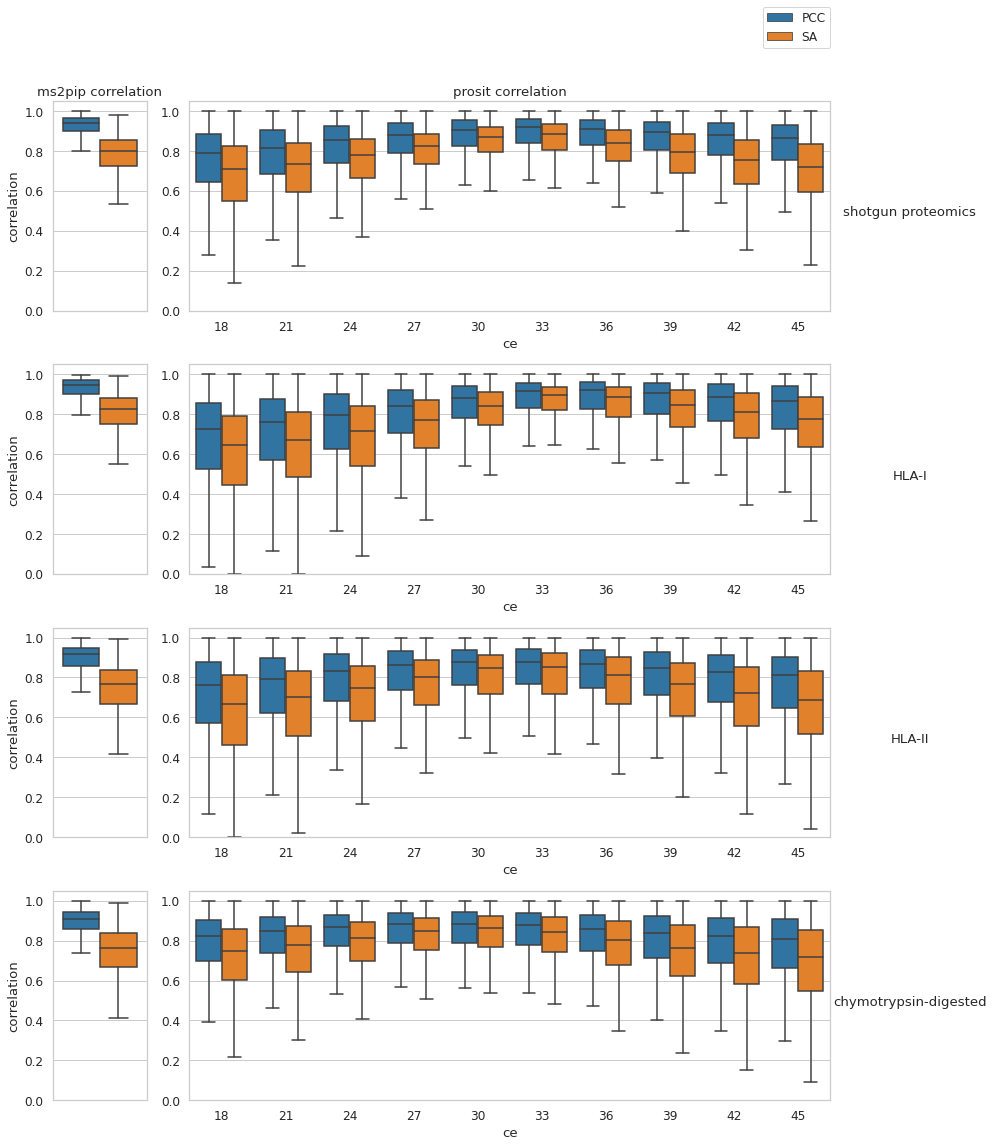

In [24]:
fig = plt.Figure(figsize=(14,16))

model_map = {
    "shotgun proteomics": "Immuno-chymotrypsin model",
    "HLA-I": "Immunopeptide model",
    "HLA-II": "Immunopeptide model",
    "chymotrypsin-digested": "Immuno-chymotrypsin model"
}

for i, testset in enumerate(["shotgun proteomics", "HLA-I", "HLA-II", "chymotrypsin-digested"]):

    ax1 = plt.subplot2grid((4,6),(i,0), fig=fig)
    sns.boxplot(
        data=ms2pip_corr[
            (ms2pip_corr["testset"] == testset) & 
            (ms2pip_corr["spec_id"].isin(prosit_correlations["spec_id"]))
            ],
        x="testset",
        y="correlation",
        hue="correlation metric",
        ax=ax1,
        showfliers=False
        )
    ax1.set_ylim(0,1.05)
    ax1.get_legend().remove()
    ax1.set(xticklabels=[], xlabel="")

    ax2 = plt.subplot2grid((4,6),(i,1), colspan=5, fig=fig, sharey=ax1)
    sns.boxplot(
        x="ce",
        y="correlation",
        hue="correlation metric",
        data=prosit_cor[prosit_cor["testset"] == testset],
        showfliers=False,
        ax=ax2
        )
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel(f"{testset}", rotation=0, labelpad=80)
    if i==0:
        ax1.set_title("ms2pip correlation")
        ax2.set_title("prosit correlation")
        ax2.legend(bbox_to_anchor=(1.01,1.48))

    else:
        ax2.get_legend().remove()


fig.tight_layout()
fig.savefig("data/Figures/FigureS7.svg")
fig

